# Simple predictor for error based analysis

2023-12-24 by @jpgil

This notebook is available in Google Colaboratory at https://colab.research.google.com/github/paranal-sw/parlogs-observations/blob/main/notebooks/03-error-based-analysis.ipynb

Below is an example with a real use case for the dataset. It implements a feature extraction in the logtext column (the error code, or *errcode*) and do a simple assumption to explain and predict execution failures. The method is simple to be used as a barebones for other kind of analysis.

## Imports and Dataset

In [1]:
import os
import re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    precision_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
)

# Set the warning mode to 'None' to suppress the warning SettingWithCopyWarning
pd.options.mode.chained_assignment = None

### Load Dataset

In [2]:
from urllib.request import urlretrieve
def direct_load(fname):
    if not os.path.exists(f'{PATH}/{fname}'):
        urlretrieve(f'{REPO_URL}/{fname}', f'{PATH}/{fname}')
    df=pd.read_parquet(f'{PATH}/{fname}')
    return df


In [3]:
INSTRUMENT='GRAVITY'
RANGE='1m'
REPO_URL='https://huggingface.co/datasets/Paranal/parlogs-observations/resolve/main/data'
PATH='sample_data' # Convenient name to be Colab compatible

!mkdir -p $PATH

df_meta = direct_load(f'{INSTRUMENT}-{RANGE}-meta.parket')
df_inst = direct_load(f'{INSTRUMENT}-{RANGE}-traces.parket')
df_subs = direct_load(f'{INSTRUMENT}-{RANGE}-traces-SUBSYSTEMS.parket')
df_tele = direct_load(f'{INSTRUMENT}-{RANGE}-traces-TELESCOPES.parket')

## Overview

In VLTSW there are some kind of event logs with logtype=ERR. These events usually denotes failures or unexpected conditions in the system, but not necessarily leads to an failed observation. The errors are shown in the logtext column and has the general format:

```bash
{module}ERR_{name} : {Detail}
```

Some ERR examples are:

In [4]:
with pd.option_context('display.max_colwidth', None):
    display(df_inst[ df_inst['logtype']=='ERR' ][['system', 'logtype', 'module', 'logtext']])

,system,logtype,module,logtext
1238,GRAVITY,ERR,ic0lcu,ic0lcuERR_SEM_CMD_LOCKED : Command semaphore locked. Probably another command is executing.
1239,GRAVITY,ERR,lcctoo,lcctooERR_SEM_TAKE : Take semaphore failed (vxWorks error 3997700)
1241,GRAVITY,ERR,lcctoo,lcctooERR_SEM_TAKE : Take semaphore failed (vxWorks error 3997700)
1242,GRAVITY,ERR,ic0lcu,ic0lcuERR_SEM_CMD_LOCKED : Command semaphore locked. Probably another command is executing.
1278,GRAVITY,ERR,lcctoo,lcctooERR_SEM_TAKE : Take semaphore failed (vxWorks error 3997700)
...,...,...,...,...
1626930,GRAVITY,ERR,cai,caiERR_WRITE : database direct write attribute failed (Direct Address: PLIN=124 - AIN=66)
1626931,GRAVITY,ERR,cai,caiERR_WRITE : database direct write attribute failed (Direct Address: Record=[0;4] - Field=[0;3])
1626932,GRAVITY,ERR,cai,caiERR_WRITE : database direct write attribute failed (Direct Address: PLIN=124 - AIN=67)
1626933,GRAVITY,ERR,cai,caiERR_WRITE : database direct write attribute failed (Buffer Size=80 bytes - DataType(1st element)=48)


We will implement two straight tokenizations to logtext:

1. ```errcode = {module}ERR_{name}``` only

In successful executions, the different ```errcode``` that appears in the traces do not lead to an failure, therefore they can be collected and marked as **harmless errors**. Those ```errcode``` in failed executions are likely causes for the failure, and can be used as predictors because they appears before the last error in BOB.

2. ```errcode : {errdata}``` where ```{errdata}``` is the ```{Detail}``` restricted to alphabet chars only. 

The same criteria applies, but in this case the details are taken in account, however simplified by restricting their character to ```[a-zA-Z]``` only to have a controlled vocabulary diverse enough to retain information.

## Split dataset

### Filter and preprocess traces 

All the traces are merged and filtered by ERR only

In [5]:
df_all = pd.concat([df_inst, df_subs, df_tele]).sort_values('@timestamp').reset_index(drop=True)
print(f'There all {len(df_all)} total traces')

df_all = df_all[ df_all['logtype']=='ERR']
print(f'After filtering, there are {len(df_all)} ERR traces')

There all 3541706 total traces
After filtering, there are 848633 ERR traces


### Feature Extraction

Two new columns are added with the ```errcode``` and ```errdata``` extracted from logtext. Note that some logtype=ERR do not has ```errcode```, this happens usally in BOB. Those events are discarded.

In [6]:
# Feature extraction 

def extract_errcode(x):
    return x.split()[0] if 'ERR_' in x else '' 

def extract_errdata(x):
    # Given the nature of error logs, the majority uses the pattern .+ERR_.+, but other important ERR logs must be used as is.
    if 'ERR_' in x:
        errdata=' '.join(x.split()[2:])
        return re.sub(r'[^a-zA-Z\ ]', ' ', errdata)
    else:
        return ''


In [7]:
df_all['errcode'] = df_all['logtext'].apply( extract_errcode )
df_all['errdata'] = df_all['logtext'].apply( extract_errdata )

print(f'{len(df_all[ df_all["errcode"]=="" ])} empty errcodes about to be discarded of  {len(df_all)} events in trace')

df_all = df_all[ df_all["errcode"]!="" ]


215 empty errcodes about to be discarded of  848633 events in trace


In [8]:
with pd.option_context('display.max_colwidth', None):
    display(df_all[['logtext', 'errcode', 'errdata']])

,logtext,errcode,errdata
352,evhERR_CMD_NOT_CHECKED : Command SETUP not checked sent by proc issifControl on env wvgvlti,evhERR_CMD_NOT_CHECKED,Command SETUP not checked sent by proc issifControl on env wvgvlti
432,"eccsERR_BUF_TOO_BIG : Buffer too big. Size: 703, Max allowed size: 176, Buffer: atagwsCON_SETUP::Set...",eccsERR_BUF_TOO_BIG,Buffer too big Size Max allowed size Buffer atagwsCON SETUP Set
438,"eccsERR_BUF_TOO_BIG : Buffer too big. Size: 703, Max allowed size: 176, Buffer: atagwsCON_SETUP::Set...",eccsERR_BUF_TOO_BIG,Buffer too big Size Max allowed size Buffer atagwsCON SETUP Set
449,"eccsERR_BUF_TOO_BIG : Buffer too big. Size: 703, Max allowed size: 176, Buffer: atagwsCON_SETUP::Set...",eccsERR_BUF_TOO_BIG,Buffer too big Size Max allowed size Buffer atagwsCON SETUP Set
483,"eccsERR_BUF_TOO_BIG : Buffer too big. Size: 703, Max allowed size: 176, Buffer: atagwsCON_SETUP::Set...",eccsERR_BUF_TOO_BIG,Buffer too big Size Max allowed size Buffer atagwsCON SETUP Set
...,...,...,...
3541678,caiERR_WRITE : database direct write attribute failed (Direct Address: PLIN=124 - AIN=67),caiERR_WRITE,database direct write attribute failed Direct Address PLIN AIN
3541679,caiERR_WRITE : database direct write attribute failed (Buffer Size=80 bytes - DataType(1st element)=48),caiERR_WRITE,database direct write attribute failed Buffer Size bytes DataType st element
3541681,dlpxposERR_TEST : Metrology test failed - Low quality,dlpxposERR_TEST,Metrology test failed Low quality
3541682,dlpxposERR_LASER_SIGNAL : Lost Laser Metrology input signal - Check cables,dlpxposERR_LASER_SIGNAL,Lost Laser Metrology input signal Check cables


### Label traces by state

Split executions that failed and execution that didn't failed (successful + aborted)

In [9]:
df_meta_success = df_meta[ df_meta['ERROR']==False ]
df_meta_success['STATE'] = 'Success'

df_meta_failed  = df_meta[ df_meta['ERROR']==True ]
df_meta_failed['STATE']  = 'Failed'

print(f'Of all executions, {len(df_meta_failed)} failed and {len(df_meta_success)} were successful')

# Label traces by its execution state -- NOT USED
# df_all.loc[ df_all['trace_id'].isin(df_meta_success.index), 'STATE'] = 'Success'
# df_all.loc[ df_all['trace_id'].isin(df_meta_failed.index ), 'STATE'] = 'Failed'

# df_all[['logtext', 'errcode', 'errdata', 'STATE']]

Of all executions, 92 failed and 676 were successful


## Train Test Split

Now we will separate the executions in two groups for training and for testing. Then we will collect the traces of each group and train the model with traces.

The work units are executions in df_meta, we need to split those items. The two classes {successful, failed} are not balanced, therefore we will do it manually using a ${train}/{total}$ factor will merge the successful and failed executions into single dataframes manually instead of using the traditional ```sklearn.model_selection.train_test_split``` method.



In [10]:
# Train Test factor
FACTOR=0.66

In [11]:
# 1. Split the executions, in df_meta_*

# Randomize
df_meta_success=df_meta_success.sample(frac=1)
df_meta_failed =df_meta_failed.sample(frac=1)

len_S_train = int( len(df_meta_success) * FACTOR )
len_F_train = int( len(df_meta_failed) * FACTOR )

# Up to len_*_train
X_meta_train = pd.concat([df_meta_success[:len_S_train], df_meta_failed[:len_F_train]])

len_S_test = len(df_meta_success) - len_S_train
len_F_test = len(df_meta_failed) - len_F_train

# From len_*_test until end
X_meta_test  = pd.concat([df_meta_success[-len_S_test:],  df_meta_failed[-len_F_test:]])

print(f'Train ({len_S_train}+{len_F_train}) + Test ({len_S_test}+{len_F_test}) = {len_S_train+len_F_train+len_S_test+len_F_test} / {len(df_meta)}')

Train (446+60) + Test (230+32) = 768 / 768


The train/test set is tricket. It is a list of dataframes of the traces corresponding to execution=trace_id. 

In [12]:
# 2. Collect traces for each execution type


# Trace dataframe as inputs
# X_train[0] contains all traces for first execution of X_meta_train
X_train = [ df_all[ df_all['trace_id'] == trace_id ] for trace_id in X_meta_train.index  ]
X_test  = [ df_all[ df_all['trace_id'] == trace_id ] for trace_id in X_meta_test.index  ]

y_train = X_meta_train['STATE'].to_list()
y_test  = X_meta_test['STATE'].to_list()

print(f'X_train={len(X_train)}, X_test={len(X_test)}, y_train={len(y_train)}, y_test={len(y_test)}')

# display(X_meta_train[:1])
# display(X_train[0][['@timestamp', 'logtext', 'STATE']])
# display(y_train[0])

X_train=506, X_test=262, y_train=506, y_test=262


## Models

All the models below uses the same strategy: if LOG is in Success, then LOG is harmless.
We will use the skickit-learn interface to take leverage of their evaluation facilities

### Evaluation

In [13]:
def eval_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row sums

    # disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Failed', 'Success'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Failed', 'Success'])
    disp.plot();

    print("Accuracy:", accuracy_score(y_pred, y_test))
    print("F1 Score:", f1_score(y_pred, y_test, average="weighted"))
    display(cm)

### Example Model

In [14]:
class VltErrPredictor1:

    _harmless_errcodes = []
    _errcodes_difference = []

    # def __init__(self) -> None:
    #     self._harmless_errcodes = []

    def fit(self, X, y):
        self._harmless_errcodes = []
        for df, state in zip(X, y):
            # If STATE = success, this errcode don't lead to a failed execution necessarily
            if state=='Success':
                errcodes = list(df['errcode'].unique())
                self._harmless_errcodes += errcodes

        self._harmless_errcodes = list(set(self._harmless_errcodes))
        return True
    
    def predict(self, X):
        # Check if any of the errcodes is not harmless
        harmless = set(self._harmless_errcodes)
        result = []
        self._errcodes_difference = []
        for df in X:
            errcodes = set(df['errcode'].unique()) 
            if len(errcodes.difference(harmless)) > 0:
                result.append('Failed')
            else:
                result.append('Success')
            self._errcodes_difference.append( list(errcodes.difference(harmless)) )
        return result


In [15]:
model = VltErrPredictor1()
model.fit(X_train, y_train)

True

In [16]:
# Example: predict some values
print('Success?', model.predict([df_all[ df_all['trace_id']==trace_id ] for trace_id in df_meta_success[:5].index ]))
print('Failed?', model.predict([df_all[ df_all['trace_id']==trace_id ] for trace_id in df_meta_failed[-5:].index ]))

Success? ['Success', 'Success', 'Success', 'Success', 'Success']
Failed? ['Success', 'Success', 'Failed', 'Failed', 'Success']


### Base model

The experiments below uses the same base model and changes the feature extraction: only errcodes, only errdata, etc.

In [17]:
class VltErrPredictorFeature:

    _harmless_features = []
    _features_difference = []

    def __init__(self, feature):
        self.feature = feature

    def fit(self, X, y):
        self._harmless_features = []
        for df, state in zip(X, y):
            # If STATE = success, this errcode don't lead to a failed execution necessarily
            if state=='Success':
                features = self.feature(df)
                self._harmless_features += features

        self._harmless_features = list(set(self._harmless_features))
            return True
    
    def predict(self, X):
        # Check if any of the features is not harmless
        harmless = set(self._harmless_features)
        result = []
        self._features_difference = []
        for df in X:
            features = set( self.feature(df) ) 
            if len(features.difference(harmless)) > 0:
                result.append('Failed')
            else:
                result.append('Success')
            self._features_difference.append( list(features.difference(harmless)) )
        return result


### Model 1: errcode only

Accuracy: 0.8473282442748091
F1 Score: 0.8453483802995454


array([[ 13,  19],
       [ 21, 209]])

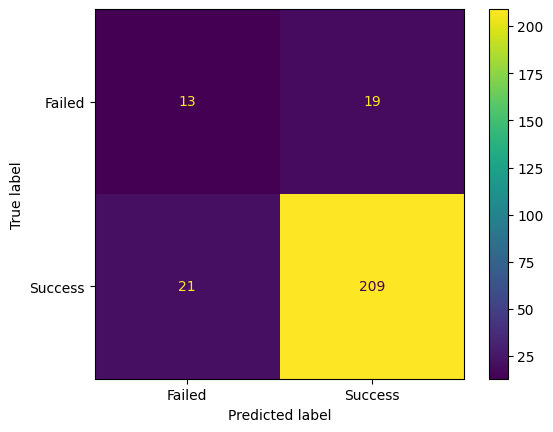

In [18]:
def feature1(df):
    return list(df['errcode'].unique())

model = VltErrPredictorFeature(feature1)
eval_model(model) 


### Model 2: errdata only

Accuracy: 0.8396946564885496
F1 Score: 0.8182837482912744


array([[ 28,   4],
       [ 38, 192]])

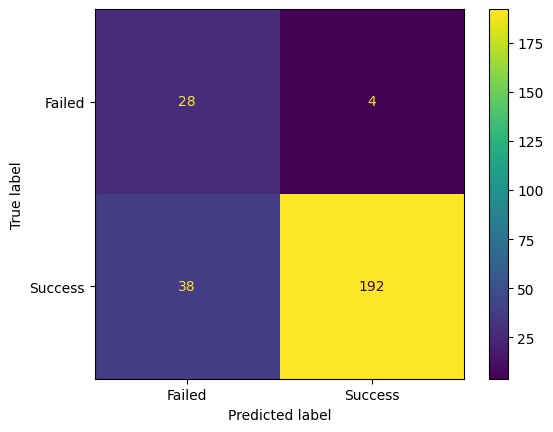

In [19]:
def feature2(df):
    return list(df['errdata'].unique())

model = VltErrPredictorFeature(feature2)
eval_model(model) 


### Model 3: errcode + errdata

Now we will include errcode + errdata, which was previously pre processed to remove numbers and symbols. The training will be done by using 

```python
(df_all['errcode'] + df_all['errdata']).unique()
```

Accuracy: 0.8358778625954199
F1 Score: 0.8136243440239849


array([[ 28,   4],
       [ 39, 191]])

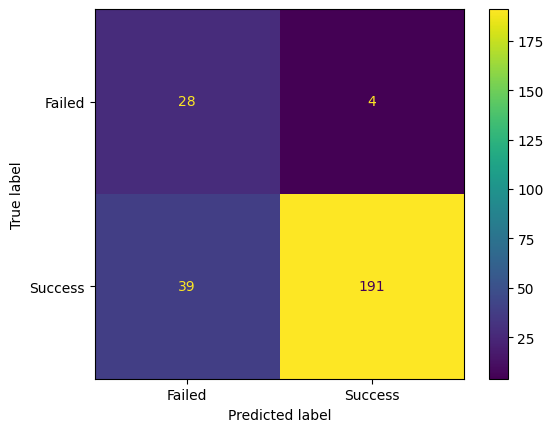

In [20]:
def feature3(df):
    return list((df['errcode'] + df['errdata']).unique())

model = VltErrPredictorFeature(feature3)
eval_model(model) 

### Model 4: procname + errcode

The system will remove numbers for AT1 AT2 AT3 AT4 becomes simply AT

Accuracy: 0.8587786259541985
F1 Score: 0.8430022487684024


array([[ 26,   6],
       [ 31, 199]])

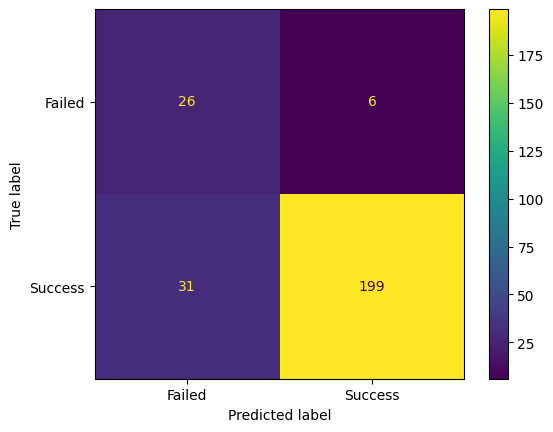

In [21]:
def feature4(df):
    text = list((df['procname'] + ' ' + df['errcode']).unique())
    text = [ re.sub(r'[0-9]', '', t) for t in text ]
    return text

model = VltErrPredictorFeature(feature4)
eval_model(model) 
# model._errcodes_difference

### Model 5: errcode without module name

nmmgrERR_ABORTED -> ABORTED

Accuracy: 0.8587786259541985
F1 Score: 0.8430022487684024


array([[ 26,   6],
       [ 31, 199]])

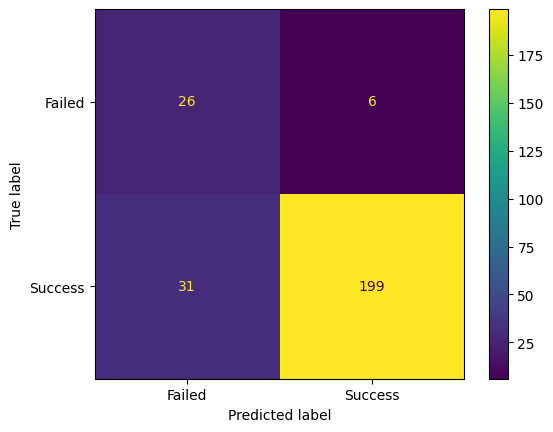

In [22]:
def feature4(df):
    text = list((df['procname'] + ' ' + df['errcode']).unique())
    text = [ re.sub(r'[0-9]', '', t) for t in text ]
    text = [ re.sub(r'\w+ERR_', '', t) for t in text ]
    return text

model = VltErrPredictorFeature(feature4)
eval_model(model) 
# model._errcodes_difference